<a href="https://colab.research.google.com/github/renaldoaluska/pbagasal2025-klp11-garuda/blob/main/2-Garuda%20Indonesia%20News%20Articles%20/2-2-Data%20Praprocessing%20News%20Articles/garuda_indonesia_article_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garuda Indonesia Article EDA

In [ ]:
import os, re, ast, math
from collections import Counter, defaultdict
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Memuat Data
Memuat dataset dari file CSV `5-garudaindonesia_news_stem.csv` ke dalam Pandas DataFrame.

In [ ]:
df = pd.read_csv('6-garudaindonesia_news_stem_tag_new_dan_sentiment.csv')

### 2. Eksplorasi Data Awal
Melihat 5 baris pertama DataFrame dan mengidentifikasi kolom teks utama (`konten_stem`). Juga memeriksa kolom lain yang bertipe objek.

In [ ]:
df.head(5)

link  \
0  https://kumparan.com/kumparanbisnis/garuda-ind...   
1  https://www.bloombergtechnoz.com/detail-news/8...   
2  https://voi.id/ekonomi/519004/komisi-v-dpr-bak...   
3  https://www.kompasiana.com/zainularifin2714/68...   
4  https://www.cnnindonesia.com/ekonomi/202509292...   

                                               judul  \
0  Garuda Indonesia Kembali RUPSLB di Tengah Isu ...   
1  Garuda Gelar RUPSLB di Tengah Isu Masuknya Dir...   
2  Komisi V DPR Bakal Dalami Dugaan Mafia Jual Be...   
3  Rencana Merger Garuda Indonesia - Pelita Air: ...   
4  Dony Oskaria Pastikan Merger Pelita Air-Garuda...   

                                              konten     tanggal  \
0  Garuda Indonesia Kembali RUPSLB di Tengah Isu ...  30/09/2025   
1  Garuda Gelar RUPSLB di Tengah Isu Masuknya Dir...  29/09/2025   
2  JAKARTA - Ketua Komisi V DPR Lasarus mengataka...  29/09/2025   
3  Latar Belakang\nPada pertengahan 2023, wacana ...  29/09/2025   
4  --\nPlt Menteri Badan Usaha Milik Negara (BUMN...  29/09/2025   

              portal               tag  \
0           Kumparan         Manajemen   
1  Bloomberg Technoz         Manajemen   
2             VOI.ID  Rute/Operasional   
3     Kompasiana.com           Lainnya   
4      CNN Indonesia           Lainnya   

                               konten_hapus_karakter  \
0  garuda indonesia kembali rupslb di tengah isu ...   
1  garuda gelar rupslb di tengah isu masuknya dir...   
2  jakarta ketua komisi v dpr lasarus mengatakan ...   
3  latar belakang pada pertengahan wacana konsoli...   
4  plt menteri badan usaha milik negara bumn seka...   

                                   konten_normalized  \
0  garuda indonesia kembali rupslb di tengah isu ...   
1  garuda gelar rupslb di tengah isu masuknya dir...   
2  jakarta ketua komisi v dpr lasarus mengatakan ...   
3  latar belakang pada pertengahan wacana konsoli...   
4  plt menteri badan usaha milik negara bumn seka...   

                                       konten_nostop  \
0  garuda indonesia rupslb tengah isu petinggi si...   
1  garuda gelar rupslb tengah isu masuknya direks...   
2  jakarta ketua komisi v dpr lasarus mengatakan ...   
3  latar belakang pertengahan wacana konsolidasi ...   
4  plt menteri badan usaha milik negara bumn seka...   

                                         konten_stem sentiment  \
0  garuda indonesia rupslb tengah isu petinggi si...   Neutral   
1  garuda gelar rupslb tengah isu masuk direksi a...   Neutral   
2  jakarta ketua komisi v dpr lasarus kata dalam ...  Negative   
3  latar belakang tengah wacana konsolidasi maska...   Neutral   
4  plt menteri badan usaha milik negara bumn seka...   Neutral   

                   tag_new  
0       Kinerja & Keuangan  
1     Regulasi & Kebijakan  
2     Krisis & Kontroversi  
3       Kinerja & Keuangan  
4  Operasional & Pelayanan

In [ ]:
# STEP 2: Tentukan kolom teks utama dan lihat contoh

TEXT_COL = "konten_stem"

if TEXT_COL not in df.columns:
    raise ValueError(f"Kolom '{TEXT_COL}' tidak ditemukan di dataset!")

print("TEXT_COL =", TEXT_COL)

# 5 contoh awal
display(df[[TEXT_COL]].head(5))

# Lihat daftar kolom teks (object) lain untuk cross-check
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
print("Kolom bertipe object:", obj_cols[:30])  # batasi tampilan sampai 30 kolom

TEXT_COL = konten_stem


konten_stem
0  garuda indonesia rupslb tengah isu petinggi si...
1  garuda gelar rupslb tengah isu masuk direksi a...
2  jakarta ketua komisi v dpr lasarus kata dalam ...
3  latar belakang tengah wacana konsolidasi maska...
4  plt menteri badan usaha milik negara bumn seka...

Kolom bertipe object: ['link', 'judul', 'konten', 'tanggal', 'portal', 'tag', 'konten_hapus_karakter', 'konten_normalized', 'konten_nostop', 'konten_stem', 'sentiment', 'tag_new']


### 3. Pembersihan Data
Memeriksa dan menangani nilai yang hilang (`NaN`) dan duplikat persis di kolom teks utama.

In [ ]:
# Cek kualitas dasar (missing values & duplikat) di kolom teks

n_docs = len(df)
missing = df[TEXT_COL].isna().sum()
dupes   = df[TEXT_COL].duplicated(keep=False).sum()

print(f"Jumlah dokumen total : {n_docs}")
print(f"Missing/NaN          : {missing} baris ({missing/n_docs:.2%})")
print(f"Duplikat persis      : {dupes} baris ({dupes/n_docs:.2%})")

# Tampilkan contoh baris yang kosong (kalau ada)
if missing > 0:
    display(df[df[TEXT_COL].isna()].head(5))


Jumlah dokumen total : 469
Missing/NaN          : 0 baris (0.00%)
Duplikat persis      : 0 baris (0.00%)


### 4. Analisis Distribusi Panjang Teks
Menghitung dan menampilkan statistik deskriptif untuk panjang teks dalam karakter dan token. Memvisualisasikan distribusi jumlah token per dokumen.

Statistik panjang karakter:
count     469.000000
mean     1784.289979
std       889.983550
min        36.000000
25%      1180.000000
50%      1680.000000
75%      2152.000000
max      7826.000000
Name: _char_len, dtype: float64

Statistik panjang token:
count     469.000000
mean      264.353945
std       133.759010
min         6.000000
25%       175.000000
50%       247.000000
75%       327.000000
max      1207.000000
Name: _token_len, dtype: float64


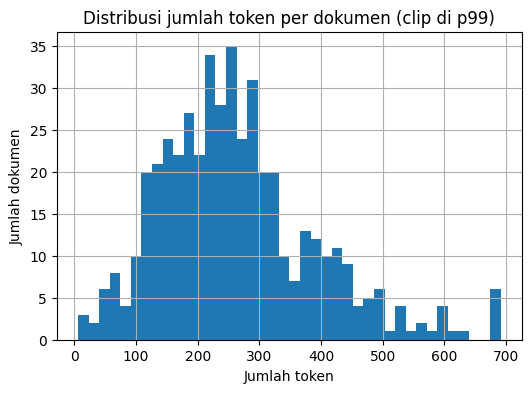

In [ ]:
#  Distribusi panjang teks (karakter & token)

df["_char_len"] = df[TEXT_COL].astype(str).str.len()

df["_token_len"] = df[TEXT_COL].astype(str).str.split().apply(len)

print("Statistik panjang karakter:")
print(df["_char_len"].describe())

print("\nStatistik panjang token:")
print(df["_token_len"].describe())

# plot distribusi jumlah token

plt.figure(figsize=(6,4))
df["_token_len"].clip(upper=df["_token_len"].quantile(0.99)).hist(bins=40)
plt.title("Distribusi jumlah token per dokumen (clip di p99)")
plt.xlabel("Jumlah token")
plt.ylabel("Jumlah dokumen")
plt.show()

In [ ]:
#Clean baris NaN di text_col

# Hapus baris NaN di kolom teks
df_clean = df.dropna(subset=[TEXT_COL]).copy()

# Hapus baris yang teksnya kosong string ("" atau " ")
df_clean = df_clean[df_clean[TEXT_COL].astype(str).str.strip() != ""]

print("Setelah cleaning (tanpa hapus duplikat):")
print(f"Jumlah dokumen: {len(df_clean)}")
print(f"Missing values : {df_clean[TEXT_COL].isna().sum()}")
print(f"Teks kosong    : {(df_clean[TEXT_COL].astype(str).str.strip() == '').sum()}")


Setelah cleaning (tanpa hapus duplikat):
Jumlah dokumen: 469
Missing values : 0
Teks kosong    : 0


### 5. Normalisasi dan Tokenisasi
Mendefinisikan fungsi untuk normalisasi dan tokenisasi teks. Mengaplikasikan fungsi ini ke kolom teks utama untuk menghasilkan daftar token per dokumen.

Ukuran kosakata : 5956
10 kata paling sering:
garuda          3670
indonesia       3223
pesawat         3039
terbang         1949
sebut           1289
tumpang         1058
jadi            1021
laku            883
jakarta         850
kata            823

Jumlah kata yang muncul sekali (hapax): 2170 (36.4% dari vocab)


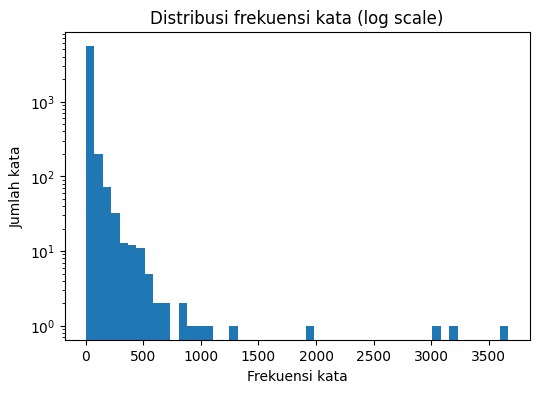

In [ ]:
# fungsi normalisasi + tokenisasi sederhana
TOKEN_RE = re.compile(r"[^0-9a-zA-Z\u00C0-\u024F\u1E00-\u1EFF'\s]+")  # hapus simbol selain huruf/angka

def normalize(text: str) -> str:
    text = text.lower()
    text = TOKEN_RE.sub(" ", text)   # ganti simbol non-alfanumerik jadi spasi
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    text = normalize(text)
    return text.split()

df_clean["_tokens"] = df_clean[TEXT_COL].astype(str).apply(tokenize)

# hitung frekuensi kata (term frequency)
token_counter = Counter(chain.from_iterable(df_clean["_tokens"]))

print("Ukuran kosakata :", len(token_counter))
print("10 kata paling sering:")
for tok, cnt in token_counter.most_common(10):
    print(f"{tok:15s} {cnt}")

# cek rare words
hapax = sum(1 for t,c in token_counter.items() if c == 1)
print(f"\nJumlah kata yang muncul sekali (hapax): {hapax} ({hapax/len(token_counter):.1%} dari vocab)")

# distribusi frekuensi kata
freqs_sorted = sorted(token_counter.values(), reverse=True)

plt.figure(figsize=(6,4))
plt.hist(freqs_sorted, bins=50, log=True)
plt.title("Distribusi frekuensi kata (log scale)")
plt.xlabel("Frekuensi kata")
plt.ylabel("Jumlah kata")
plt.show()

### 6. Analisis Frekuensi Kata
Menghitung frekuensi setiap token di seluruh korpus dan menampilkan 10 kata yang paling sering muncul. Juga memeriksa jumlah kata yang hanya muncul sekali (hapax) dan memvisualisasikan distribusi frekuensi kata.

In [ ]:
# Rare Words Removal (pakai cutoff min_count=2)

MIN_COUNT = 2

rare_words = {t for t,c in token_counter.items() if c < MIN_COUNT}

print(f"Jumlah kata yang akan dihapus: {len(rare_words)} "
      f"({len(rare_words)/vocab_size:.1%} dari vocab)")

# filter token
def filter_tokens(tokens, to_remove):
    return [t for t in tokens if t not in to_remove]

df_clean["tokens_clean"] = df_clean["_tokens"].apply(lambda toks: filter_tokens(toks, rare_words))
df_clean["konten_stem_clean"]   = df_clean["tokens_clean"].apply(lambda toks: " ".join(toks))

# cek hasil
print("Contoh sebelum -> sesudah:")
for i in range(3):
    print("RAW :", df_clean["_tokens"].iloc[i])
    print("CLEAN:", df_clean["tokens_clean"].iloc[i])
    print("---")


Jumlah kata yang akan dihapus: 2170 (36.4% dari vocab)
Contoh sebelum -> sesudah:
RAW : ['garuda', 'indonesia', 'rupslb', 'tengah', 'isu', 'petinggi', 'singapore', 'airlines', 'masuk', 'september', 'wib', 'waktu', 'baca', 'menitgaruda', 'indonesia', 'rupslb', 'tengah', 'isu', 'petinggi', 'singapore', 'airlines', 'masuk', 'belum', 'garuda', 'indonesia', 'gelar', 'rupslb', 'hingga', 'malam', 'juli', 'lalu', 'bulan', 'depan', 'rapat', 'tengah', 'kabar', 'direksi', 'asing', 'masuk', 'jadi', 'dirkeu', 'kumparanbisnis', 'advertisement', 'pt', 'garuda', 'indonesia', 'persero', 'tbk', 'giaa', 'gelar', 'rapat', 'umum', 'pegang', 'saham', 'luar', 'biasa', 'rupslb', 'tengah', 'ramai', 'kabar', 'soal', 'mungkin', 'gabung', 'salah', 'satu', 'petinggi', 'singapore', 'airlines', 'jajar', 'manajemen', 'maskapai', 'pelat', 'merah', 'sebut', 'rupslb', 'ada', 'oktober', 'tangerang', 'advertisement', 'kutip', 'buka', 'informasi', 'bursa', 'efek', 'indonesia', 'bei', 'selasa', 'panggil', 'resmi', 'rapat', 

Total rare words (count < 2): 2,170
Frekuensi minimum saat ini: 1 (menampilkan 40 contoh)


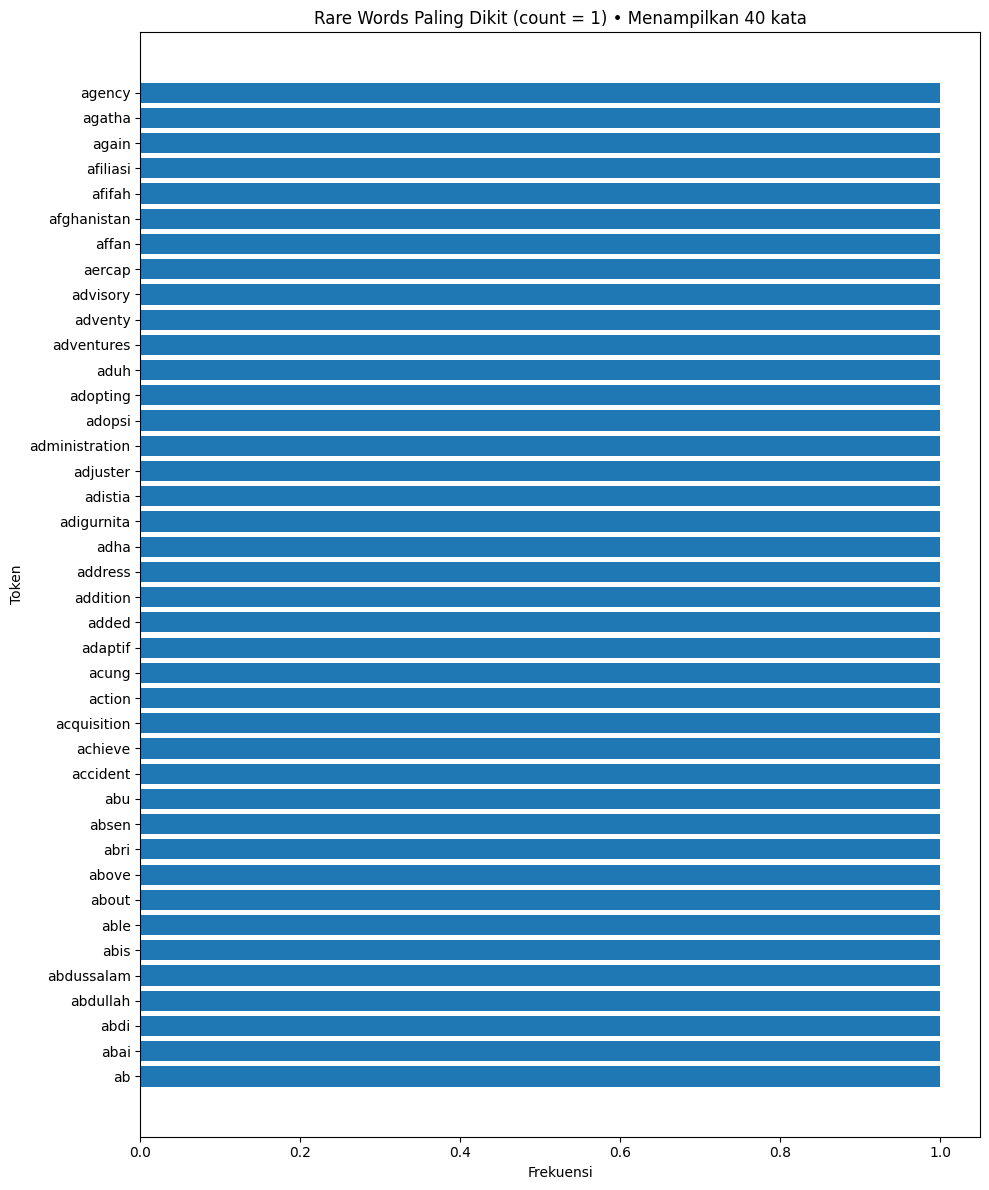

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Param ---
N = 40  # berapa kata "paling dikit" yang mau ditampilkan

# Buat dataframe frekuensi
df_freq = pd.DataFrame(list(token_counter.items()), columns=["token","count"])

# Ambil hanya rare words (sesuai cutoff MIN_COUNT)
rare_df = df_freq[df_freq["count"] < MIN_COUNT].copy()

if rare_df.empty:
    print("Tidak ada rare words (semua kata memenuhi MIN_COUNT).")
else:
    # Fokus ke yang PALING dikit (count minimum)
    min_count = rare_df["count"].min()
    rarest = rare_df[rare_df["count"] == min_count].sort_values(["count","token"], ascending=[True, True])

    # Ambil N teratas (alfabetis untuk konsisten)
    rarest_head = rarest.head(N)

    print(f"Total rare words (count < {MIN_COUNT}): {len(rare_df):,}")
    print(f"Frekuensi minimum saat ini: {min_count} (menampilkan {len(rarest_head)} contoh)")

    # Plot horizontal bar chart
    plt.figure(figsize=(10, max(4, 0.3*len(rarest_head))))
    plt.barh(rarest_head["token"], rarest_head["count"])
    plt.xlabel("Frekuensi")
    plt.ylabel("Token")
    plt.title(f"Rare Words Paling Dikit (count = {min_count}) • Menampilkan {len(rarest_head)} kata")
    plt.tight_layout()
    plt.show()


In [ ]:
# Eksplor cutoff rare words

# distribusi frekuensi
freqs = np.array(list(token_counter.values()))

total_token = freqs.sum()
vocab_size  = len(freqs)

print(f"Total token di korpus: {total_token}")
print(f"Vocab size: {vocab_size}")

# fungsi bantu: berapa banyak kata/token terhapus jika cutoff tertentu
def cutoff_stats(k):
    removed_vocab = np.sum(freqs < k)
    removed_token = np.sum(freqs[freqs < k])
    return {
        "cutoff": k,
        "removed_vocab": removed_vocab,
        "removed_vocab_pct": removed_vocab / vocab_size,
        "removed_token": removed_token,
        "removed_token_pct": removed_token / total_token
    }

# cek untuk cutoff 2,3,5
for k in [2,3,5]:
    stats = cutoff_stats(k)
    print(
        f"\nmin_count >= {k}: "
        f"hapus {stats['removed_vocab']} kata unik "
        f"({stats['removed_vocab_pct']:.1%} vocab), "
        f"hilang {stats['removed_token_pct']:.1%} token"
    )

# lihat cutoff coverage otomatis
freqs_sorted = np.sort(freqs)[::-1]
cum = np.cumsum(freqs_sorted) / total_token

for cov in [0.95, 0.97, 0.99]:
    idx = np.searchsorted(cum, cov)
    print(f"Coverage {int(cov*100)}% tercapai dengan {idx} kata paling sering")


Total token di korpus: 123982
Vocab size: 5956

min_count >= 2: hapus 2170 kata unik (36.4% vocab), hilang 1.8% token

min_count >= 3: hapus 2955 kata unik (49.6% vocab), hilang 3.0% token

min_count >= 5: hapus 3686 kata unik (61.9% vocab), hilang 5.0% token
Coverage 95% tercapai dengan 2274 kata paling sering
Coverage 97% tercapai dengan 3011 kata paling sering
Coverage 99% tercapai dengan 4716 kata paling sering


### 7. Penghapusan Kata Langka (Rare Words)
Menentukan nilai minimum kemunculan (MIN_COUNT) untuk menghapus kata-kata langka. Kata-kata yang muncul kurang dari MIN_COUNT akan dihapus dari daftar token setiap dokumen.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# freq sebelum & sesudah
freq_before = Counter()
for toks in df_clean["_tokens"]:
    freq_before.update(toks)

freq_after = Counter()
for toks in df_clean["tokens_clean"]:
    freq_after.update(toks)

vocab_before = len(freq_before)
vocab_after  = len(freq_after)
tokens_before = sum(freq_before.values())
tokens_after  = sum(freq_after.values())

print(f"Vocab before : {vocab_before:,}")
print(f"Vocab after  : {vocab_after:,}  ({(vocab_after/vocab_before):.1%} of before)")
print(f"Tokens before: {tokens_before:,}")
print(f"Tokens after : {tokens_after:,}  ({(tokens_after/tokens_before):.1%} of before)")
print(f"Rare words removed (< {MIN_COUNT}): {len(rare_words):,}  ({len(rare_words)/vocab_before:.1%} of vocab)")


Vocab before : 5,956
Vocab after  : 3,786  (63.6% of before)
Tokens before: 123,982
Tokens after : 121,812  (98.2% of before)
Rare words removed (< 2): 2,170  (36.4% of vocab)


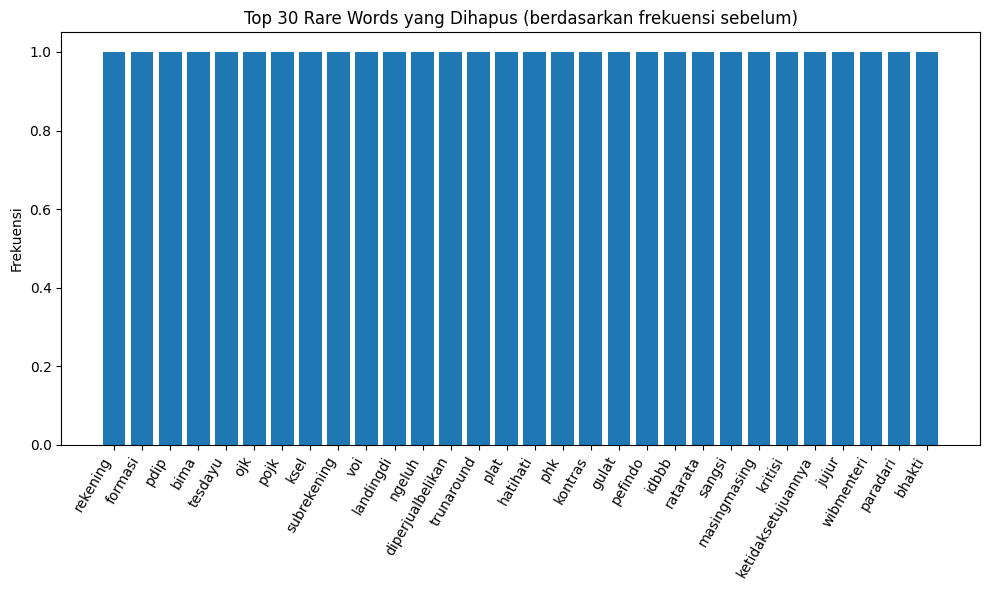

In [ ]:
# ambil frekuensi sebelum untuk kata-kata rare (c < MIN_COUNT)
removed_freq = {t:c for t,c in freq_before.items() if t in rare_words}
removed_sorted = sorted(removed_freq.items(), key=lambda x: x[1], reverse=True)[:30]

if removed_sorted:
    words, counts = zip(*removed_sorted)
    plt.figure(figsize=(10,6))
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=60, ha='right')
    plt.title(f"Top {len(words)} Rare Words yang Dihapus (berdasarkan frekuensi sebelum)")
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kata rare yang dihapus (removed_sorted kosong).")


Jumlah kata unik sekarang: 3,786
Frekuensi terkecil saat ini: 2
Jumlah kata dengan frekuensi 2: 785


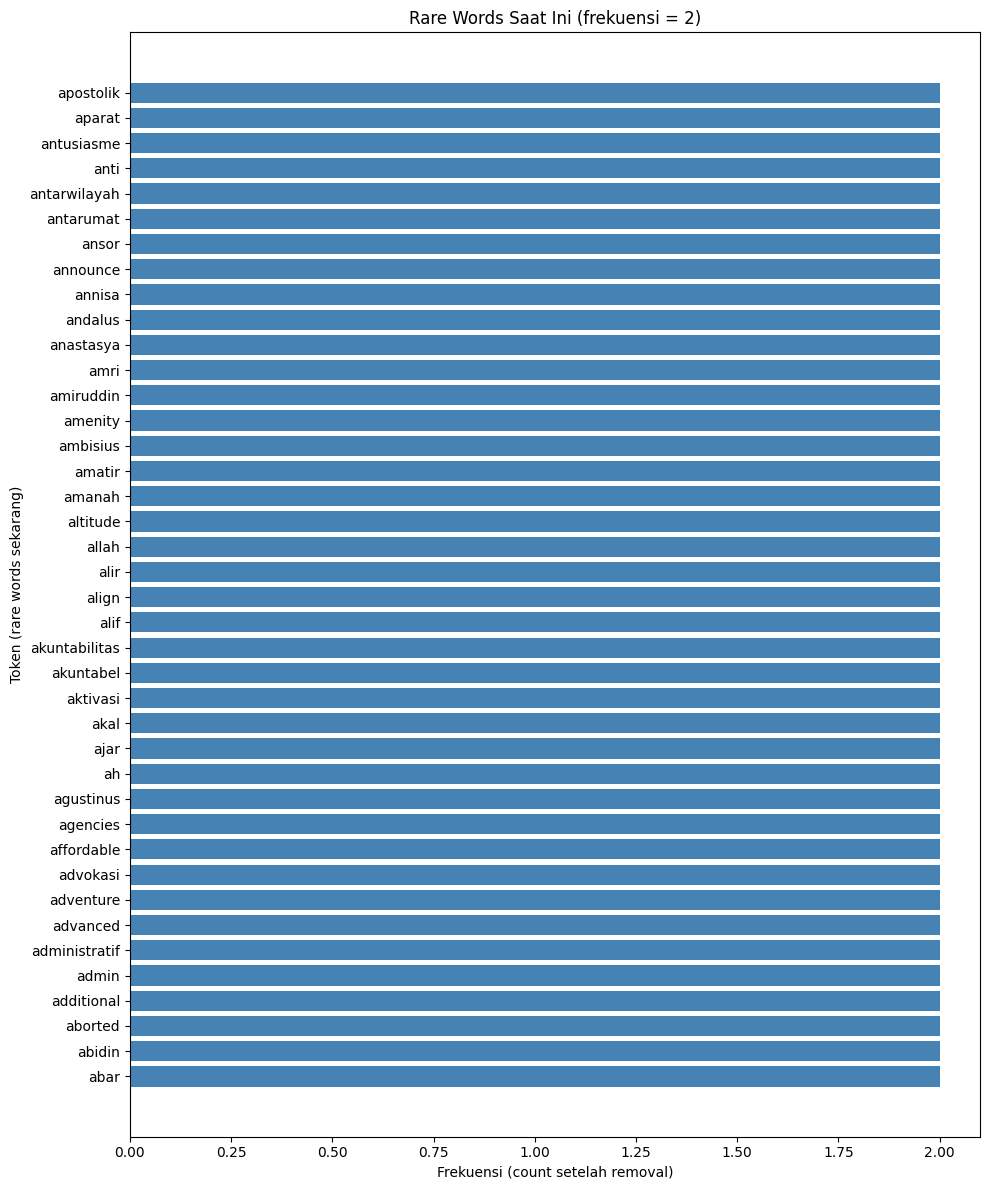

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# --- Hitung ulang frekuensi dari hasil clean ---
token_counter_after = Counter([t for toks in df_clean["tokens_clean"] for t in toks])
df_freq_after = pd.DataFrame(list(token_counter_after.items()), columns=["token","count"])

# --- Cari rare words sekarang ---
min_count_after = df_freq_after["count"].min()  # frekuensi terkecil yang masih ada
rare_now = df_freq_after[df_freq_after["count"] == min_count_after].sort_values("token")

print(f"Jumlah kata unik sekarang: {len(df_freq_after):,}")
print(f"Frekuensi terkecil saat ini: {min_count_after}")
print(f"Jumlah kata dengan frekuensi {min_count_after}: {len(rare_now):,}")

# --- Visualisasi (Top-N) ---
N = 40  # tampilkan 40 rare words terendah
top_rare_now = rare_now.head(N)

plt.figure(figsize=(10, max(4, 0.3*len(top_rare_now))))
plt.barh(top_rare_now["token"], top_rare_now["count"], color="steelblue")
plt.xlabel("Frekuensi (count setelah removal)")
plt.ylabel("Token (rare words sekarang)")
plt.title(f"Rare Words Saat Ini (frekuensi = {min_count_after})")
plt.tight_layout()
plt.show()


In [ ]:
# Hapus dokumen kosong setelah rare words removal

before = len(df_clean)

# Buang baris yang text_clean kosong ("") atau NaN
df_clean = df_clean.dropna(subset=["text_clean"])
df_clean = df_clean[df_clean["text_clean"].str.strip() != ""]

after = len(df_clean)

print(f"Jumlah dokumen sebelum drop : {before}")
print(f"Jumlah dokumen sesudah drop : {after}")
print(f"Jumlah baris kosong yang dihapus: {before - after}")


Jumlah dokumen sebelum drop : 469
Jumlah dokumen sesudah drop : 469
Jumlah baris kosong yang dihapus: 0


In [ ]:
cols_to_save = ["link","judul","konten","tanggal","portal","tag","konten_hapus_karakter","konten_normalized","konten_nostop","konten_stem","konten_stem_clean","sentiment","tag_new"]
df_clean[cols_to_save].to_csv("/content/garudaindonesia_news_cleaned_simple.csv", index=False, encoding="utf-8-sig")


Ukuran kosakata baru: 3786
10 kata paling sering (setelah cleaning):
garuda          3670
indonesia       3223
pesawat         3039
terbang         1949
sebut           1289
tumpang         1058
jadi            1021
laku            883
jakarta         850
kata            823

Statistik panjang token (setelah cleaning):
count     469.000000
mean      259.727079
std       130.843116
min         6.000000
25%       174.000000
50%       244.000000
75%       322.000000
max      1196.000000
Name: _token_len_clean, dtype: float64


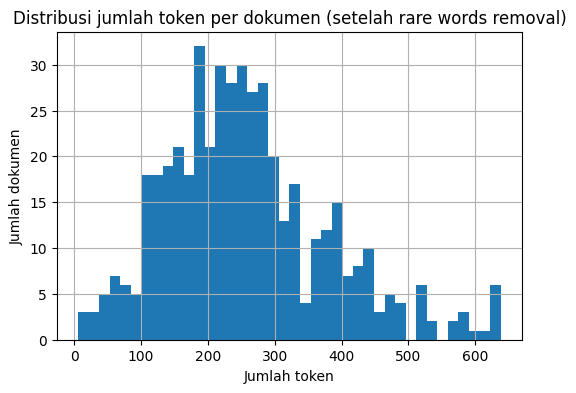

In [ ]:
# Explore lagi setelah removal

# hitung frekuensi kata baru
clean_counter = Counter(chain.from_iterable(df_clean["tokens_clean"]))
vocab_new = len(clean_counter)

print("Ukuran kosakata baru:", vocab_new)
print("10 kata paling sering (setelah cleaning):")
for tok, cnt in clean_counter.most_common(10):
    print(f"{tok:15s} {cnt}")

# panjang token per dokumen setelah cleaning
df_clean["_token_len_clean"] = df_clean["tokens_clean"].apply(len)

print("\nStatistik panjang token (setelah cleaning):")
print(df_clean["_token_len_clean"].describe())

# plot distribusi panjang token setelah cleaning
plt.figure(figsize=(6,4))
df_clean["_token_len_clean"].clip(upper=df_clean["_token_len_clean"].quantile(0.99)).hist(bins=40)
plt.title("Distribusi jumlah token per dokumen (setelah rare words removal)")
plt.xlabel("Jumlah token")
plt.ylabel("Jumlah dokumen")
plt.show()

/tmp/ipython-input-2579064431.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="viridis")


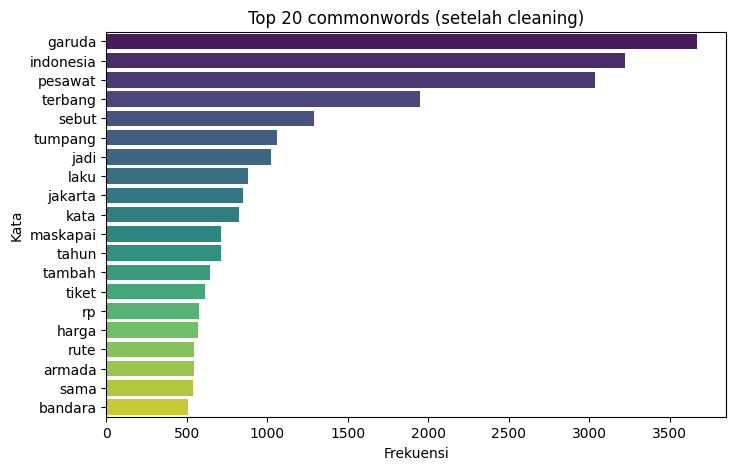

In [ ]:
# Barplot commonwords
import matplotlib.pyplot as plt
import seaborn as sns

top_words = pd.DataFrame(clean_counter.most_common(20), columns=["word","count"])

plt.figure(figsize=(8,5))
sns.barplot(y="word", x="count", data=top_words, palette="viridis")
plt.title("Top 20 commonwords (setelah cleaning)")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()


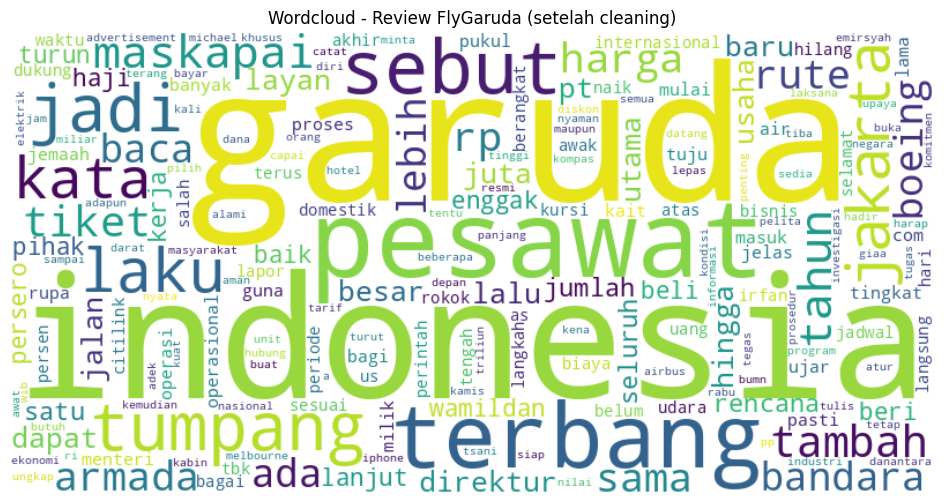

In [ ]:
#  Wordcloud
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis")\
     .generate_from_frequencies(clean_counter)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Review FlyGaruda (setelah cleaning)")
plt.show()


In [ ]:
# Bigram (2-kata) paling sering
from collections import Counter

def get_ngrams(tokens, n=2):
    return zip(*[tokens[i:] for i in range(n)])

bigram_counter = Counter()
for toks in df_clean["tokens_clean"]:
    bigram_counter.update(get_ngrams(toks, n=2))

top_bigrams = bigram_counter.most_common(20)
print("Top 20 bigram:")
for bg, cnt in top_bigrams:
    print(f"{' '.join(bg):20s} {cnt}")


Top 20 bigram:
garuda indonesia     2623
pesawat garuda       459
pt garuda            328
harga tiket          321
tiket pesawat        269
direktur utama       263
salah satu           214
rp juta              201
indonesia persero    191
persero tbk          175
utama garuda         173
pesawat boeing       169
maskapai terbang     161
beli pesawat         153
rokok elektrik       153
wamildan tsani       151
rp triliun           147
jemaah haji          138
turun harga          135
kompas com           134


/tmp/ipython-input-3276964117.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent_counts.index, y=sent_counts.values, palette="Set2")


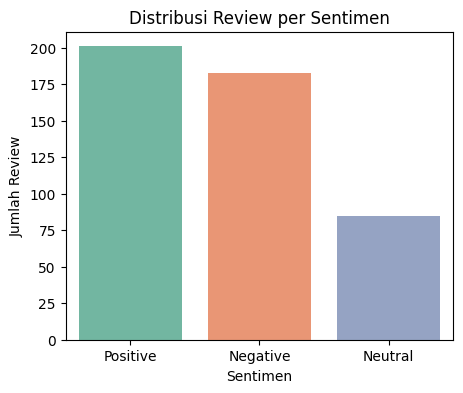

sentiment
Positive    201
Negative    183
Neutral      85
Name: count, dtype: int64


In [ ]:
# Distribusi jumlah review per sentimen

sent_counts = df_clean["sentiment"].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=sent_counts.index, y=sent_counts.values, palette="Set2")
plt.title("Distribusi Review per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

print(sent_counts)


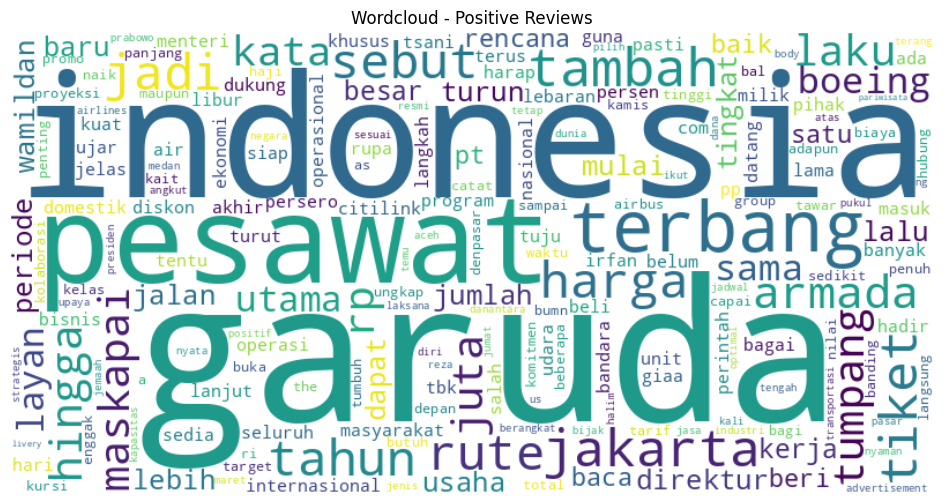

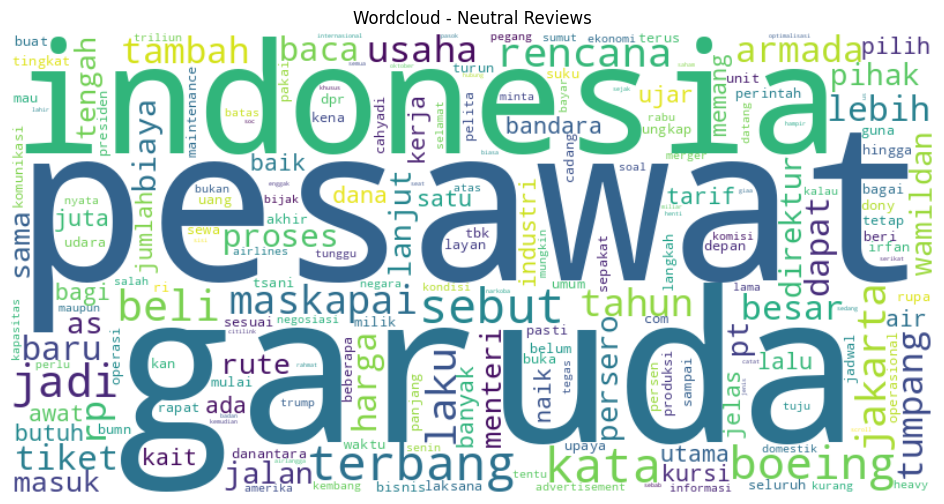

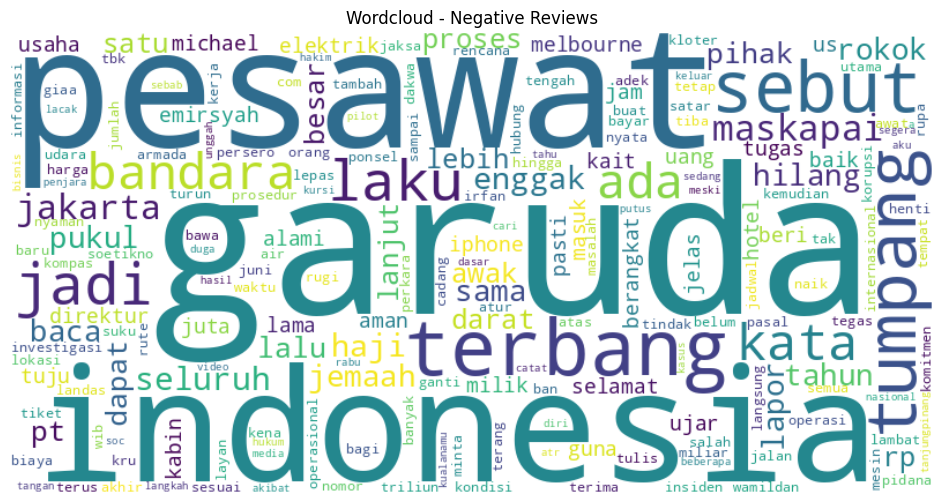

In [ ]:
# Wordcloud untuk setiap label sentimen

for label in ["Positive","Neutral","Negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]
    counter = Counter(chain.from_iterable(subset_tokens))

    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis")\
         .generate_from_frequencies(counter)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud - {label.capitalize()} Reviews")
    plt.show()

/tmp/ipython-input-1585374776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")


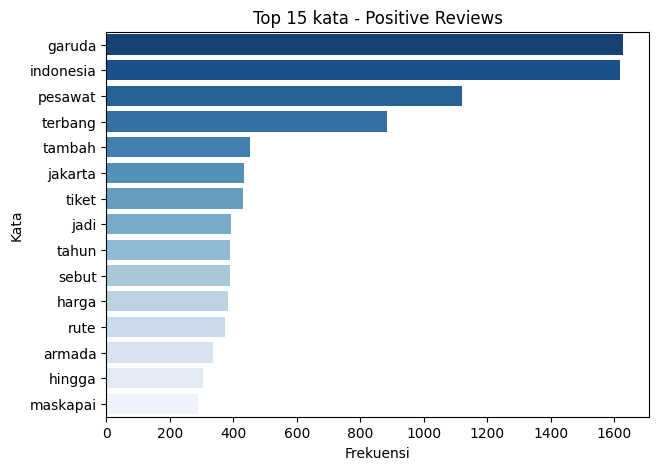

/tmp/ipython-input-1585374776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")


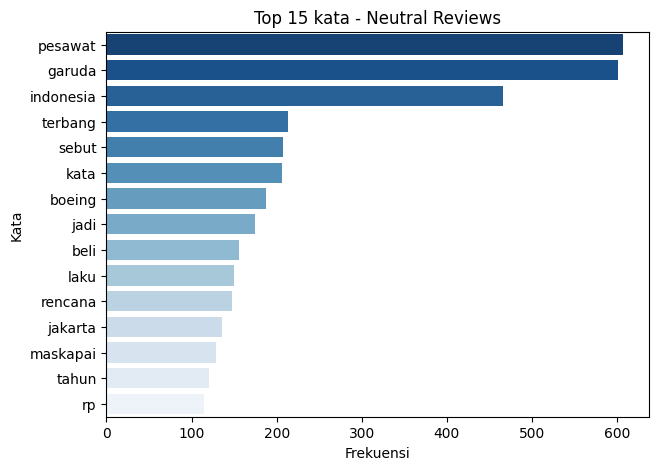

/tmp/ipython-input-1585374776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")


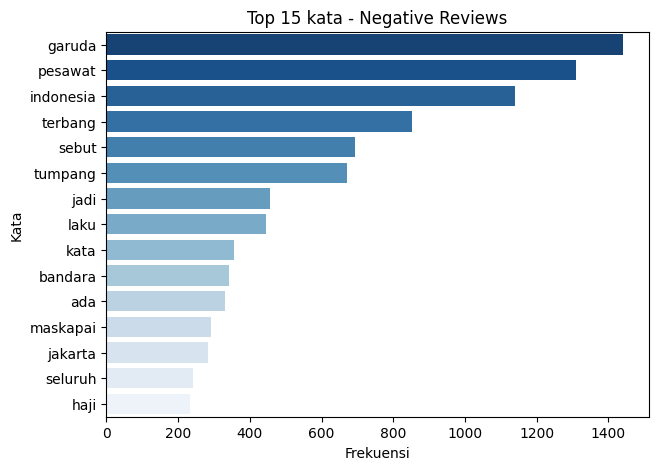

In [ ]:
# STEP 12c: Top kata per label sentimen
top_n = 15

for label in ["Positive","Neutral","Negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]
    counter = Counter(chain.from_iterable(subset_tokens))
    top_words = pd.DataFrame(counter.most_common(top_n), columns=["word","count"])

    plt.figure(figsize=(7,5))
    sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")
    plt.title(f"Top {top_n} kata - {label.capitalize()} Reviews")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
    plt.show()


In [ ]:
# STEP 13: Bigram & Trigram per sentimen
from collections import Counter

def get_ngrams(tokens, n=2):
    return list(zip(*[tokens[i:] for i in range(n)]))

for label in ["Positive","Neutral","Negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]

    # Bigram
    bigram_counter = Counter()
    for toks in subset_tokens:
        bigram_counter.update(get_ngrams(toks, n=2))

    # Trigram
    trigram_counter = Counter()
    for toks in subset_tokens:
        trigram_counter.update(get_ngrams(toks, n=3))

    print(f"\n=== {label.upper()} REVIEWS ===")
    print("Top 10 bigram:")
    for bg, cnt in bigram_counter.most_common(10):
        print(f"{' '.join(bg):20s} {cnt}")

    print("\nTop 10 trigram:")
    for tg, cnt in trigram_counter.most_common(10):
        print(f"{' '.join(tg):25s} {cnt}")



=== POSITIVE REVIEWS ===
Top 10 bigram:
garuda indonesia     1269
harga tiket          218
tiket pesawat        188
rp juta              164
direktur utama       158
pesawat garuda       151
pt garuda            136
turun harga          116
utama garuda         112
maskapai terbang     103

Top 10 trigram:
pt garuda indonesia       131
utama garuda indonesia    111
direktur utama garuda     110
turun harga tiket         107
pesawat garuda indonesia  92
harga tiket pesawat       92
garuda indonesia persero  88
mulai rp juta             75
indonesia persero tbk     74
garuda indonesia wamildan 74

=== NEUTRAL REVIEWS ===
Top 10 bigram:
garuda indonesia     366
beli pesawat         92
pesawat garuda       77
pesawat boeing       72
pt garuda            63
harga tiket          51
tiket pesawat        46
direktur utama       44
indonesia persero    41
pelita air           41

Top 10 trigram:
pt garuda indonesia       63
beli pesawat boeing       47
garuda indonesia persero  40
indonesia pe

tag  count        pct
0           Lainnya    322  68.656716
1  Rute/Operasional     97  20.682303
2          Keuangan     22   4.690832
3    Hukum/Regulasi     19   4.051173
4         Manajemen      9   1.918977

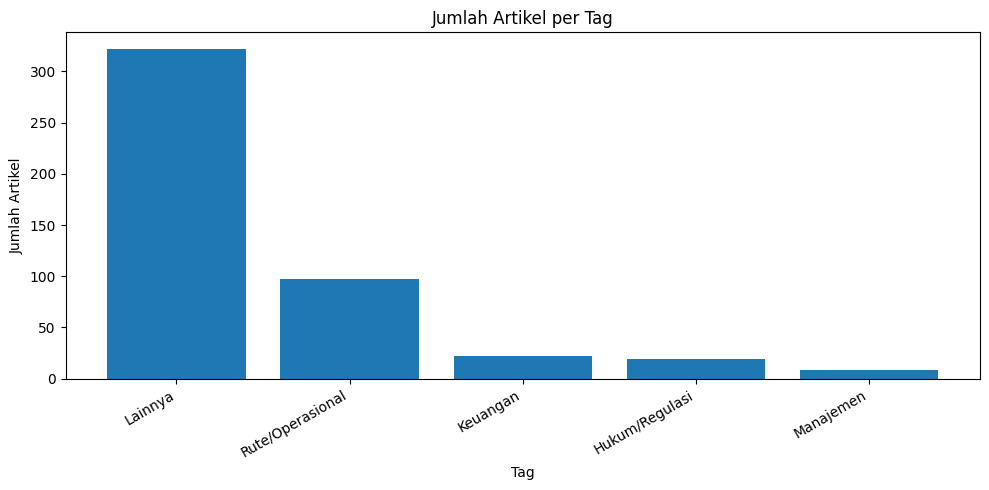

In [ ]:
# === Cell 4: Distribusi Tag ===
tag_counts = df['tag'].value_counts().rename_axis('tag').reset_index(name='count')
tag_counts['pct'] = 100 * tag_counts['count'] / tag_counts['count'].sum()

display(tag_counts)

# Plot bar
plt.figure(figsize=(10, 5))
plt.bar(tag_counts['tag'], tag_counts['count'])
plt.xticks(rotation=30, ha='right')
plt.title('Jumlah Artikel per Tag')
plt.ylabel('Jumlah Artikel')
plt.xlabel('Tag')
plt.tight_layout()
plt.show()


tag  count        pct
0         Operasional & Pelayanan    185  39.445629
1            Krisis & Kontroversi    143  30.490405
2              Kinerja & Keuangan    109  23.240938
3            Regulasi & Kebijakan     27   5.756930
4  Industri & Pariwisata Nasional      5   1.066098

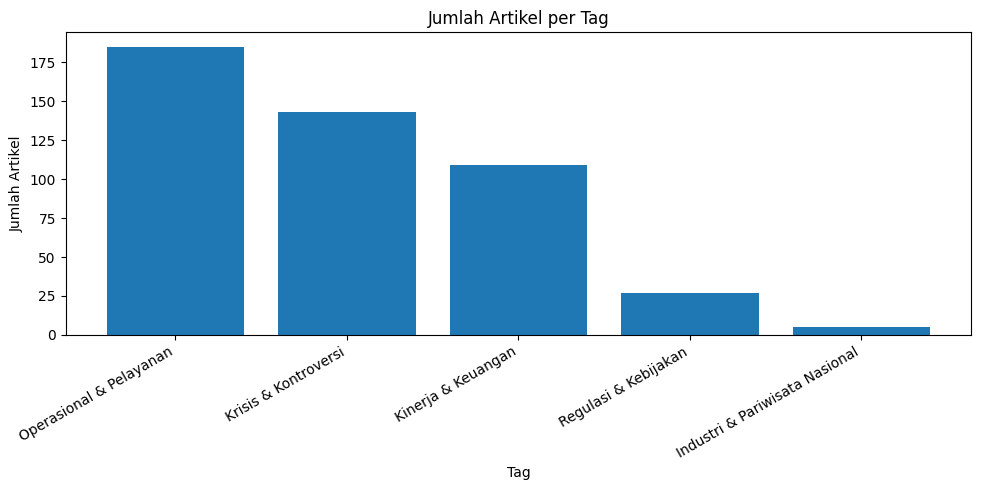

In [ ]:
# === Cell 4: Distribusi Tag ===
tag_counts = df['tag_new'].value_counts().rename_axis('tag').reset_index(name='count')
tag_counts['pct'] = 100 * tag_counts['count'] / tag_counts['count'].sum()

display(tag_counts)

# Plot bar
plt.figure(figsize=(10, 5))
plt.bar(tag_counts['tag'], tag_counts['count'])
plt.xticks(rotation=30, ha='right')
plt.title('Jumlah Artikel per Tag')
plt.ylabel('Jumlah Artikel')
plt.xlabel('Tag')
plt.tight_layout()
plt.show()


In [ ]:
# === Cell 5: Top Portal per Tag ===
# Hitung jumlah artikel per (tag, portal), lalu ambil top-N portal di tiap tag
N = 5
top_portal_per_tag = (
    df.groupby(['tag_new','portal'])['link']
      .count().rename('count').reset_index()
      .sort_values(['tag_new','count'], ascending=[True, False])
)

# Ambil Top-N per tag
top_portal_per_tag = top_portal_per_tag.groupby('tag_new').head(N).reset_index(drop=True)
display(top_portal_per_tag)

# Pivot ringkas untuk melihat sebaran (isi NaN -> 0)
pivot_portal = (
    df.pivot_table(index='tag_new', columns='portal', values='link', aggfunc='count', fill_value=0)
    .sort_index()
)
pivot_portal.head(10)


tag_new                           portal  count
0   Industri & Pariwisata Nasional                   CNBC Indonesia      1
1   Industri & Pariwisata Nasional                         Detikcom      1
2   Industri & Pariwisata Nasional                  MetroTVNews.com      1
3   Industri & Pariwisata Nasional  Pemerintah Provinsi Jawa Tengah      1
4   Industri & Pariwisata Nasional                       VIVA.co.id      1
5               Kinerja & Keuangan                         Tempo.co     16
6               Kinerja & Keuangan                     detikFinance     10
7               Kinerja & Keuangan                       Bisnis.com      8
8               Kinerja & Keuangan                       Kompas.com      8
9               Kinerja & Keuangan                    CNN Indonesia      7
10            Krisis & Kontroversi                       Kompas.com     34
11            Krisis & Kontroversi                    CNN Indonesia      9
12            Krisis & Kontroversi                        detikNews      9
13            Krisis & Kontroversi                     Liputan6.com      7
14            Krisis & Kontroversi                         Tempo.co      6
15         Operasional & Pelayanan                       Kompas.com     20
16         Operasional & Pelayanan                      ANTARA News     15
17         Operasional & Pelayanan                       Bisnis.com     13
18         Operasional & Pelayanan                     Liputan6.com     12
19         Operasional & Pelayanan                   CNBC Indonesia     11
20            Regulasi & Kebijakan                       Bisnis.com      4
21            Regulasi & Kebijakan                       Kompas.com      4
22            Regulasi & Kebijakan                Bloomberg Technoz      3
23            Regulasi & Kebijakan                   CNBC Indonesia      3
24            Regulasi & Kebijakan                     Liputan6.com      2

portal                          20detik  ANTARA News  \
tag_new                                                
Industri & Pariwisata Nasional        0            0   
Kinerja & Keuangan                    1            4   
Krisis & Kontroversi                  2            2   
Operasional & Pelayanan               0           15   
Regulasi & Kebijakan                  0            0   

portal                          ANTARA News Bangka Belitung  Asian Aviation  \
tag_new                                                                       
Industri & Pariwisata Nasional                            0               0   
Kinerja & Keuangan                                        0               0   
Krisis & Kontroversi                                      0               0   
Operasional & Pelayanan                                   1               1   
Regulasi & Kebijakan                                      0               0   

portal                          BISNISNEWS.id  Batam Pos  Bisnis.com  \
tag_new                                                                
Industri & Pariwisata Nasional              0          0           0   
Kinerja & Keuangan                          1          0           8   
Krisis & Kontroversi                        0          1           5   
Operasional & Pelayanan                     0          0          13   
Regulasi & Kebijakan                        0          0           4   

portal                          Bloomberg Technoz  Brilio.net  CNA.id  ...  \
tag_new                                                                ...   
Industri & Pariwisata Nasional                  0           0       0  ...   
Kinerja & Keuangan                              1           0       0  ...   
Krisis & Kontroversi                            3           1       1  ...   
Operasional & Pelayanan                         1           0       0  ...   
Regulasi & Kebijakan                            3           0       0  ...   

portal                          detikOto  detikTravel  detikcom  \
tag_new                                                           
Industri & Pariwisata Nasional         0            0         0   
Kinerja & Keuangan                     1            4         1   
Krisis & Kontroversi                   0            3         5   
Operasional & Pelayanan                0            5         3   
Regulasi & Kebijakan                   0            1         0   

portal                          economy.okezone.com  konstruksimedia.com  \
tag_new                                                                    
Industri & Pariwisata Nasional                    0                    0   
Kinerja & Keuangan                                0                    0   
Krisis & Kontroversi                              1                    0   
Operasional & Pelayanan                           1                    1   
Regulasi & Kebijakan                              0                    0   

portal                          kontan.co.id  muslim.okezone.com  \
tag_new                                                            
Industri & Pariwisata Nasional             0                   0   
Kinerja & Keuangan                         0                   0   
Krisis & Kontroversi                       0                   1   
Operasional & Pelayanan                    2                   0   
Regulasi & Kebijakan                       0                   0   

portal                          republika.co.id  terkenal.co.id  waspada.id  
tag_new                                                                      
Industri & Pariwisata Nasional                0               0           0  
Kinerja & Keuangan                            0               0           0  
Krisis & Kontroversi                          0               1           1  
Operasional & Pelayanan                       1               0           0  
Regulasi & Kebijakan                          0      

In [ ]:
tag_counts = (
    df['tag_new'].value_counts(dropna=False)
    .rename_axis('tag_new')
    .reset_index(name='count')
)
tag_counts['pct'] = (tag_counts['count'] / tag_counts['count'].sum() * 100).round(2)
tag_counts


tag_new  count    pct
0         Operasional & Pelayanan    185  39.45
1            Krisis & Kontroversi    143  30.49
2              Kinerja & Keuangan    109  23.24
3            Regulasi & Kebijakan     27   5.76
4  Industri & Pariwisata Nasional      5   1.07

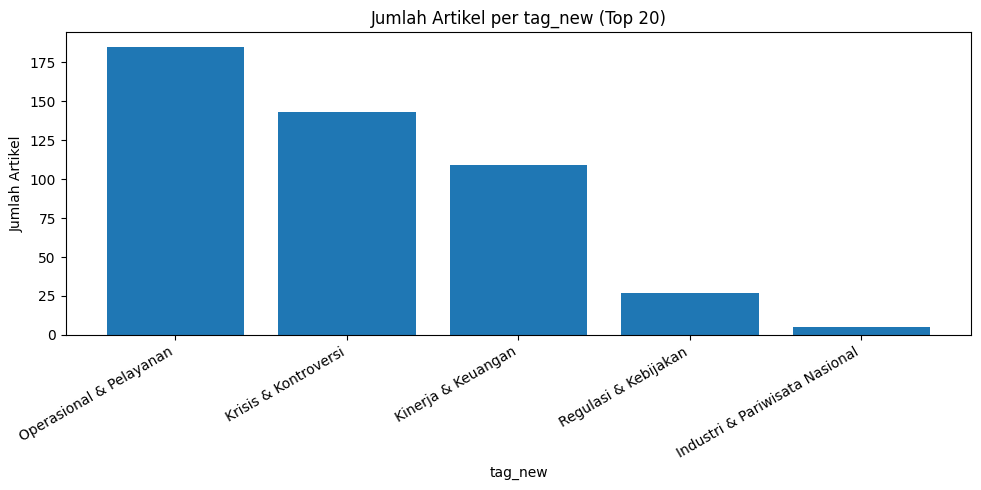

In [ ]:
N = 20  # ganti sesuai kebutuhan
topn = tag_counts.head(N)

plt.figure(figsize=(10,5))
plt.bar(topn['tag_new'].astype(str), topn['count'])
plt.xticks(rotation=30, ha='right')
plt.title(f'Jumlah Artikel per tag_new (Top {N})')
plt.ylabel('Jumlah Artikel')
plt.xlabel('tag_new')
plt.tight_layout()
plt.show()


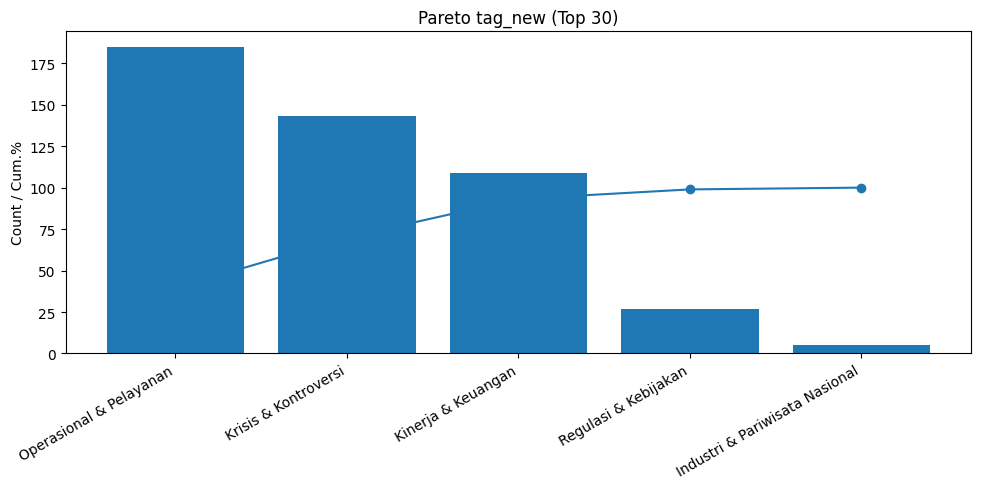

tag_new  count    pct     cum_pct
0         Operasional & Pelayanan    185  39.45   39.445629
1            Krisis & Kontroversi    143  30.49   69.936034
2              Kinerja & Keuangan    109  23.24   93.176972
3            Regulasi & Kebijakan     27   5.76   98.933902
4  Industri & Pariwisata Nasional      5   1.07  100.000000

In [ ]:
pareto = tag_counts.copy()
pareto['cum_pct'] = pareto['count'].cumsum() / pareto['count'].sum() * 100

plt.figure(figsize=(10,5))
plt.bar(pareto['tag_new'].astype(str).head(30), pareto['count'].head(30))
plt.plot(pareto['tag_new'].astype(str).head(30), pareto['cum_pct'].head(30), marker='o')
plt.xticks(rotation=30, ha='right')
plt.title('Pareto tag_new (Top 30)')
plt.ylabel('Count / Cum.%')
plt.tight_layout()
plt.show()

pareto.head(30)


/tmp/ipython-input-96292179.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ym = pd.to_datetime(df['tanggal'], errors='coerce').dt.to_period('M').astype(str)


tag_new  Industri & Pariwisata Nasional  Kinerja & Keuangan  \
ym                                                            
2024-10                             0.0                 2.0   
2024-11                             0.0                 1.0   
2024-12                             0.0                 5.0   
2025-01                             1.0                 5.0   
2025-02                             1.0                 1.0   
2025-03                             0.0                 6.0   
2025-04                             0.0                 0.0   
2025-05                             0.0                12.0   
2025-06                             1.0                 8.0   
2025-07                             1.0                27.0   
2025-08                             0.0                 1.0   
2025-09                             0.0                31.0   

tag_new  Krisis & Kontroversi  Operasional & Pelayanan  Regulasi & Kebijakan  
ym                                                                            
2024-10                   1.0                      7.0                   2.0  
2024-11                   0.0                     16.0                   4.0  
2024-12                   0.0                      9.0                   0.0  
2025-01                   1.0                     18.0                   0.0  
2025-02                   2.0                      7.0                   0.0  
2025-03                  16.0                     15.0                   4.0  
2025-04                  19.0                      4.0                   0.0  
2025-05                  16.0                     23.0                   1.0  
2025-06                  41.0                      9.0                   5.0  
2025-07                   1.0                     13.0                   3.0  
2025-08                   0.0                     14.0                   0.0  
2025-09                  12.0                     11.0                   6.0

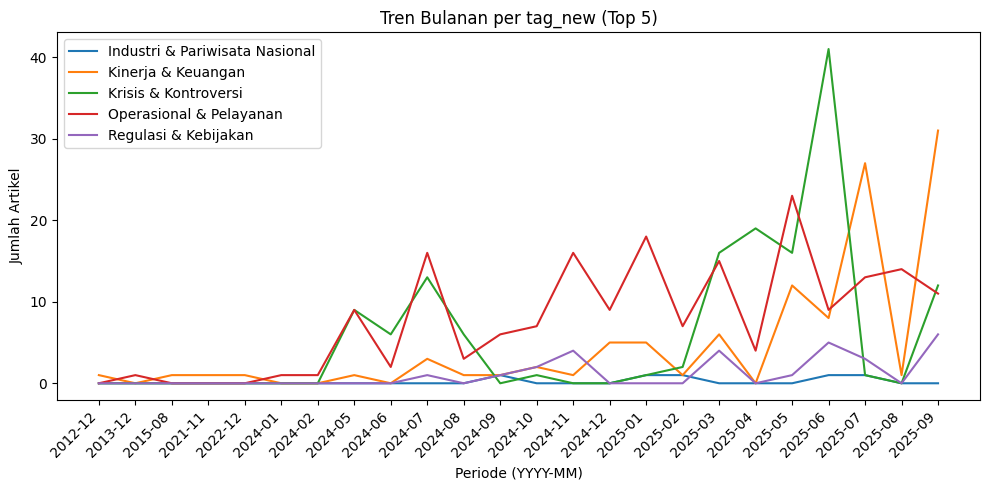

In [ ]:
assert 'tanggal' in df.columns, "Butuh kolom 'tanggal' untuk analisis tren."

# seri periode bulanan sementara (tidak menimpa df)
ym = pd.to_datetime(df['tanggal'], errors='coerce').dt.to_period('M').astype(str)

monthly = (
    pd.DataFrame({'ym': ym, 'tag_new': df['tag_new']})
      .groupby(['ym','tag_new'])
      .size().rename('count').reset_index()
      .dropna(subset=['ym'])
)

# pilih Top-K tag_new berdasarkan total count
top_k = 5
top_tags = (monthly.groupby('tag_new')['count'].sum()
            .sort_values(ascending=False).head(top_k).index.tolist())

monthly_top = monthly[monthly['tag_new'].isin(top_tags)]
trend_pivot = monthly_top.pivot(index='ym', columns='tag_new', values='count').fillna(0)
trend_pivot = trend_pivot.sort_index()

display(trend_pivot.tail(12))

plt.figure(figsize=(10,5))
for col in trend_pivot.columns:
    plt.plot(trend_pivot.index, trend_pivot[col], label=col)
plt.xticks(rotation=45, ha='right')
plt.title(f'Tren Bulanan per tag_new (Top {top_k})')
plt.ylabel('Jumlah Artikel')
plt.xlabel('Periode (YYYY-MM)')
plt.legend()
plt.tight_layout()
plt.show()


sentiment                       Negative  Neutral  Positive
tag_new                                                    
Industri & Pariwisata Nasional      0.00     0.00    100.00
Kinerja & Keuangan                 19.27    34.86     45.87
Krisis & Kontroversi               96.50     2.80      0.70
Operasional & Pelayanan            11.89    16.22     71.89
Regulasi & Kebijakan                7.41    48.15     44.44

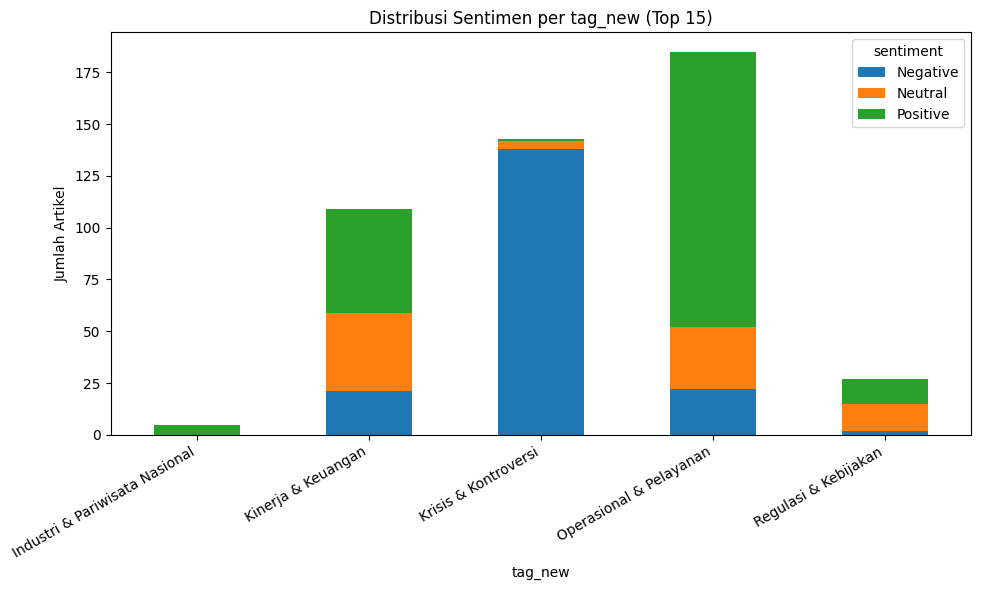

In [ ]:
if 'sentiment' in df.columns:
    ctab = pd.crosstab(df['tag_new'], df['sentiment'], normalize='index')*100
    ctab = ctab.round(2)
    display(ctab)

    # plot untuk 15 tag teratas dari distribusi
    base_order = tag_counts['tag_new'].head(15)
    raw_ctab = pd.crosstab(df['tag_new'], df['sentiment'])
    raw_ctab = raw_ctab.loc[raw_ctab.index.intersection(base_order.astype(str))]
    raw_ctab.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.xticks(rotation=30, ha='right')
    plt.title('Distribusi Sentimen per tag_new (Top 15)')
    plt.ylabel('Jumlah Artikel')
    plt.xlabel('tag_new')
    plt.tight_layout()
    plt.show()


In [ ]:
df['panjang_konten'] = df['konten_stem'].astype(str).str.len()
avg_len = df.groupby('tag_new')['panjang_konten'].mean().sort_values(ascending=False)
avg_len.head(10)


tag_new
Krisis & Kontroversi              1995.895105
Kinerja & Keuangan                1814.899083
Operasional & Pelayanan           1652.189189
Industri & Pariwisata Nasional    1507.800000
Regulasi & Kebijakan              1496.333333
Name: panjang_konten, dtype: float64

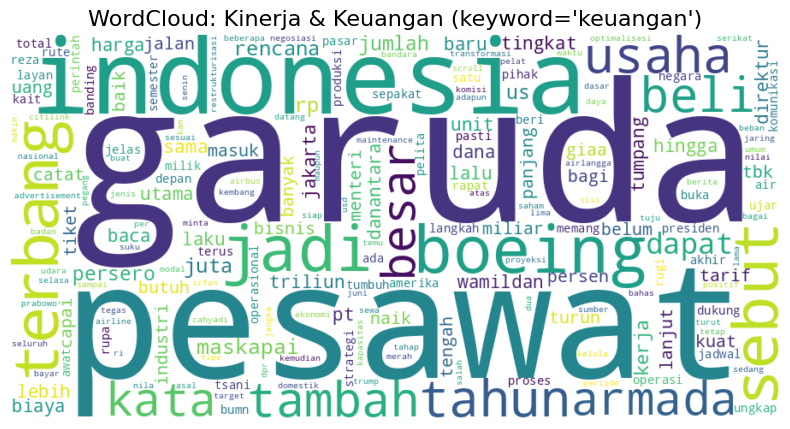

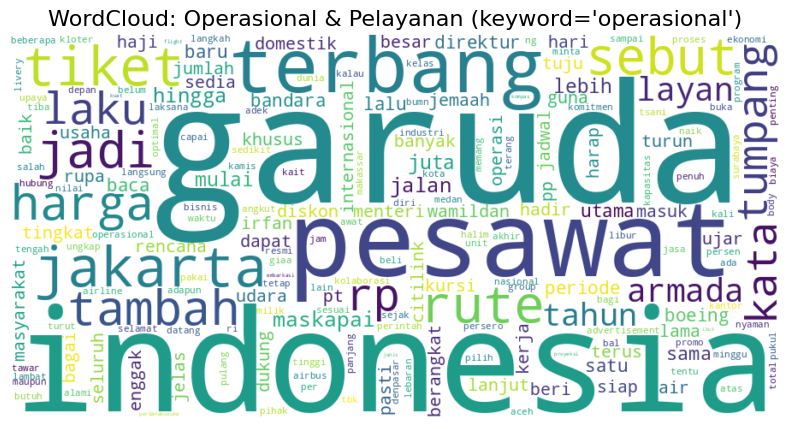

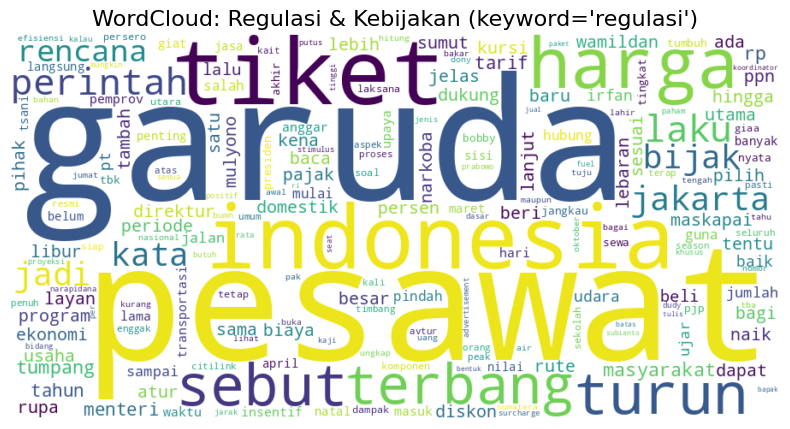

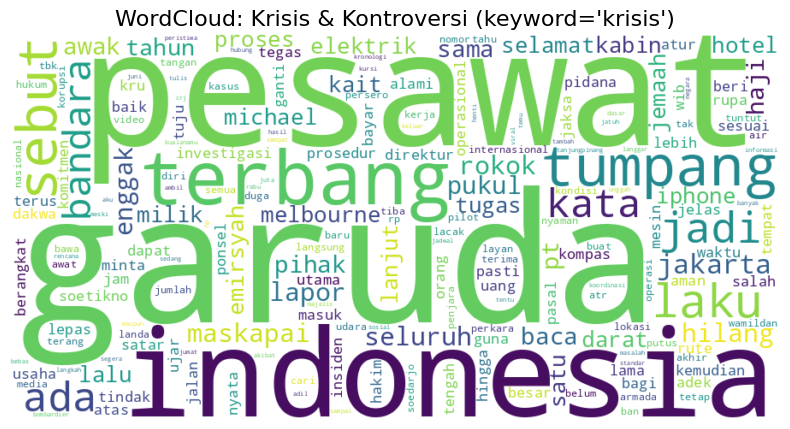

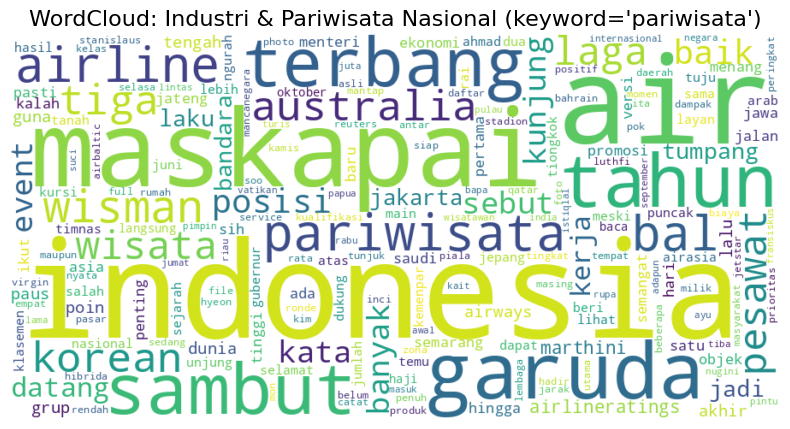

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# daftar kategori + kata kunci pencarian (bisa sebagian dari tag_new)
kategori_map = {
    "Kinerja & Keuangan": "keuangan",
    "Operasional & Pelayanan": "operasional",
    "Regulasi & Kebijakan": "regulasi",
    "Krisis & Kontroversi": "krisis",
    "Industri & Pariwisata Nasional": "pariwisata"
}

# pastikan kolomnya string
df['tag_new'] = df['tag_new'].astype(str)
df['konten_stem'] = df['konten_stem'].astype(str)

# loop tiap kategori
for nama_kat, keyword in kategori_map.items():
    # ambil semua baris di mana tag_new mengandung kata kunci (case-insensitive)
    mask = df['tag_new'].str.contains(keyword, case=False, na=False)
    subset = df.loc[mask, 'konten_stem']

    if subset.empty:
        print(f"❌ Tidak ada tag_new yang mengandung '{keyword}', dilewati.")
        continue

    # gabungkan semua teks dari subset tsb
    text = " ".join(subset)

    # buat wordcloud
    wc = WordCloud(width=900, height=450, background_color='white',
                   max_words=200, collocations=False).generate(text)

    # tampilkan
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud: {nama_kat} (keyword='{keyword}')", fontsize=16)
    plt.show()


### 8. Eksplorasi Setelah Pembersihan
Memeriksa kembali ukuran kosakata baru, 10 kata paling sering, dan statistik panjang token setelah penghapusan kata langka. Memvisualisasikan distribusi panjang token yang sudah dibersihkan.

### 9. Visualisasi Kata Paling Sering
Membuat barplot dari 20 kata yang paling sering muncul dan wordcloud dari seluruh kosakata setelah pembersihan untuk visualisasi yang lebih menarik.

### 10. Analisis N-gram
Mendefinisikan fungsi untuk mendapatkan n-gram (urutan kata-kata). Menghitung dan menampilkan 20 bigram (2-kata) yang paling sering muncul.

### 11. Analisis Sentimen
Menghitung dan menampilkan distribusi jumlah dokumen untuk setiap kategori sentimen (Positive, Neutral, Negative).

### 12. Eksplorasi Kata per Sentimen
Menganalisis kata-kata paling sering untuk setiap label sentimen. Membuat wordcloud untuk setiap sentimen.

### 13. Analisis N-gram per Sentimen
Menganalisis bigram (2-kata) dan trigram (3-kata) yang paling sering muncul untuk setiap kategori sentimen.